# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présent dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail avant le **22/04**. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [10]:
# Input : filename -> the name of the file
# Output : Dictionnary with keys is "<specie_name> DNA" and value is the DNA code
# The file must be of this format:
# <specie_name1> DNA
# DNACODE
#
# <specie_name2> DNA
# DNACODE
def import_fasta(filename):
    file = open(filename)
    lines = file.readlines()
    last = len(lines) - 1

    # We use a finite state automata
    # 0 : reading the specie name
    # 1 : reading it's dna code
    state = 0

    # We store the result in res
    res = {}
    current_key = ""
    current_val = ""
    curr_line = 0

    # Read lines
    for line in lines:
        # Read the specie name
        if state == 0:
            # Reset the current key and values
            current_key = ""
            current_val = ""

            # Fetch the line without ">""
            tmp = line[1:]

            # Fetch the name of the species without DNA at the end
            current_key = " ".join(tmp.split(" ")[:-1])

            # Switch to read DNA
            state = 1

        # Read the DNA code
        elif state == 1:

            # Fill value of dna
            if line != "\n" and curr_line != last:
            # if line != "\n":
                current_val += line.rstrip()
            # End of dna, switch to read specie name
            else:
                state = 0
                res[current_key] = current_val
        curr_line += 1
    file.close()
    return res

In [11]:
dict_cat_dna = import_fasta("cat_dna.fasta")
print(dict_cat_dna)

{'Felis Cat A': 'CCCTTACCAAAATTATTAATCACTCATTCATCGACCTACCTGCCCCATCTAACATCTCAGCATGATGAAACTTCGGCTCCCTTCTAGGAGTCTGCCTAATCTTACAAATCCTCACCGGCCTCTTTTTGGCCATACACTACACATCAGACACAACAACCGCCTTTTCATCAGTTACCCACATCTGTCGCGACGTTAATTATGGCTGAATCATCCGATATTTACACGCCAACGGAGCTTCTATATTCTTTATCTGCCTGTACATACATGTAGGACGGGGAATATACTACGG', 'Lion': 'CTTGTCAAAATTATTAATCACTCATTCATTGATCTTCCCACTCCACCCAATATCTCAGCATGATGAAACTTTGGCTCCTTATTAGGAGTATGTTTAATCCTACAAATTCTCACCGGCCTCTTTCTAGCCATACATTACACACCAGACACAATAACCGCTTTCTCATCAGTCACCCACATTTGCCGCGATGTAAACTATGGCTGAATTATCCGGTACCTACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCATGTAGGACGAGGAATATACTATGGC', 'Tiger': 'CACACCCCCTTATCAAAATTATTAATCACTCATTTATTGACCTACCCGCCCCATCCAATATTTCAGCATGATGAAACTTTGGCTCCTTACTAGGGGTGTGCTTAATCTTACAAATCCTCACTGGCCTCTTTCTAGCCATACACTACACATCAGACACAATAACCGCATTCTCATCAGTTACCCACATTTGCCGCGACGTAAACTACGGCTGGATTATCCGATATCTACATGCCAACGGAGCCTCCATATTCTTTATCTGTCTATACATGCACGTAGGACGAGGAATATAC', 'Wild Cat': 'ACCCCCTTATCAAAATTATTAATCACTCATTCATCGACCTACCCGCCCCATCTAACATCTCAGCATGATGAAACT

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 3 substitutions
- l'alignement 2 implique au minimum 1 indel et 2 substitutions
- l'alignement 3 implique au minimum 1 indel et 3 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | -5 |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [12]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [13]:
# Compute the score(difference) between two sequences

def score_sequence(seq1, seq2):

    # In case two sequence are not same length, no overflow
    length = min(len(seq1), len(seq2))

    # The final result
    sum = 0
    similarity_matrix = SimilarityMatrix('dna_matrix')
    for i in range(length):
        sum += similarity_matrix.score(seq1[i], seq2[i])
    return sum

In [14]:
A1_0 = "-ACTCCTGA"
A1_1 = "ATCTCGTGA"

A2_0 = "A-CTCCTGA"
A2_1 = "ATCTCGTGA"

A3_0 = "AC-TCCTGA"
A3_1 = "ATCTCGTGA"

print(score_sequence(A1_0, A1_1))
print(score_sequence(A2_0, A2_1))
print(score_sequence(A3_0, A3_1))

35.0
49.0
39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $n \times m$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n}$, $j \in {2, \dots, m}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [15]:
# Algorithme of Needleman_Wunsch
# Input : SequenceA => string
#         SequenceB => string
#         similarity_matrix => instance of SimilarityMatrix class
# Output : two sequence which are aligned
def Needleman_Wunsch(sequenceA, sequenceB, similarity_matrix):
    # Init the two matrix
    score_matrix = np.zeros(shape=(len(sequenceA)+1, len(sequenceB)+1))
    traceback_matrix = np.full((len(sequenceA)+1, len(sequenceB)+1), '_')
    for j in range(len(sequenceB)+1):
        score_matrix[0, j] = j*(-5)
        traceback_matrix[0, j] = 'l'
    for i in range(len(sequenceA)+1):
        score_matrix[i, 0] = i*(-5)
        traceback_matrix[i, 0] = 'u'
    traceback_matrix[0, 0] = 'o'
    # compute the two matrix
    for i in range(1, len(sequenceA)+1):
        for j in range(1, len(sequenceB)+1):
            letter1 = sequenceA[i-1]
            letter2 = sequenceB[j-1]
            m_0 = score_matrix[i-1, j-1] + \
                similarity_matrix.score(letter1, letter2)
            m_1 = score_matrix[i, j-1] + similarity_matrix.score(letter1, '-')
            m_2 = score_matrix[i-1, j] + similarity_matrix.score(letter2, '-')
            m_ij = np.max([m_0, m_1, m_2])
            score_matrix[i, j] = m_ij
            if m_ij == m_0:
                traceback_matrix[i, j] = 'd'
            elif m_ij == m_1:
                traceback_matrix[i, j] = 'l'
            else:
                traceback_matrix[i, j] = 'u'
    # create the two sequence aligned
    i = len(sequenceA)
    j = len(sequenceB)
    res1 = ""
    res2 = ""
    while(traceback_matrix[i, j] != 'o'):
        if traceback_matrix[i, j] == 'd':
            res1 = sequenceA[i-1] + res1
            res2 = sequenceB[j-1] + res2
            i -= 1
            j -= 1
        elif traceback_matrix[i, j] == 'l':
            res1 = '-' + res1
            res2 = sequenceB[j-1] + res2
            j -= 1
        else:
            res1 = sequenceA[i-1] + res1
            res2 = '-' + res2
            i -= 1
    return res1, res2

In [16]:
similarity_matrix = SimilarityMatrix('dna_matrix')
sequ_aligned = Needleman_Wunsch("ACTCCTGA","ATCTCGTGA",similarity_matrix)
print(sequ_aligned[0])
print(sequ_aligned[1])

A-CTCCTGA
ATCTCGTGA


----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [17]:
def p_distance(seq1, seq2):

    length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))

    sum = 0
    for i in range(length):
        if (seq1[i] != seq2[i] and seq1[i] != "-" and seq2[i] != "-"):
            sum += 1

    return sum/max_length


def jukes_cantor(x):
    return -(3/4) * np.log(1-(4/3)*x)

In [18]:
import multiprocessing

# Distance matrix
def distance_matrix(seq_dict, similarity_matrix):
    # Longueur
    n = len(seq_dict)

    # Tableau d'ADN
    tab = np.array([value for key, value in seq_dict.items()])

    # Result matrix
    res = np.full([n, n], np.nan)

    # Multithread job list
    jobs = []
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    for i in range(n):
        def f(i, return_dict):
            for j in range(i):
                align1, align2 = Needleman_Wunsch(
                    tab[i], tab[j], similarity_matrix)
                tmp = jukes_cantor(p_distance(align1, align2))
                return_dict[str(i) + '#' + str(j)] = tmp
        p = multiprocessing.Process(target=f, args=(i, return_dict))
        jobs.append(p)
        p.start()

    # Wait for all job to finish
    for p in jobs:
        p.join()

    # Fill the matrix
    for key in return_dict:
        tmp = key.split('#')
        i = int(tmp[0])
        j = int(tmp[1])
        res[i][j] = return_dict[key]

    return res

In [19]:
dist_mat = distance_matrix(dict_cat_dna, similarity_matrix)
print(dist_mat)

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [ 0.14708616         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [ 0.12069778  0.09725837         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [ 0.01382528  0.13319026  0.1136315          nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [ 0.11405036  0.11803443  0.10694239  0.10499039   

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

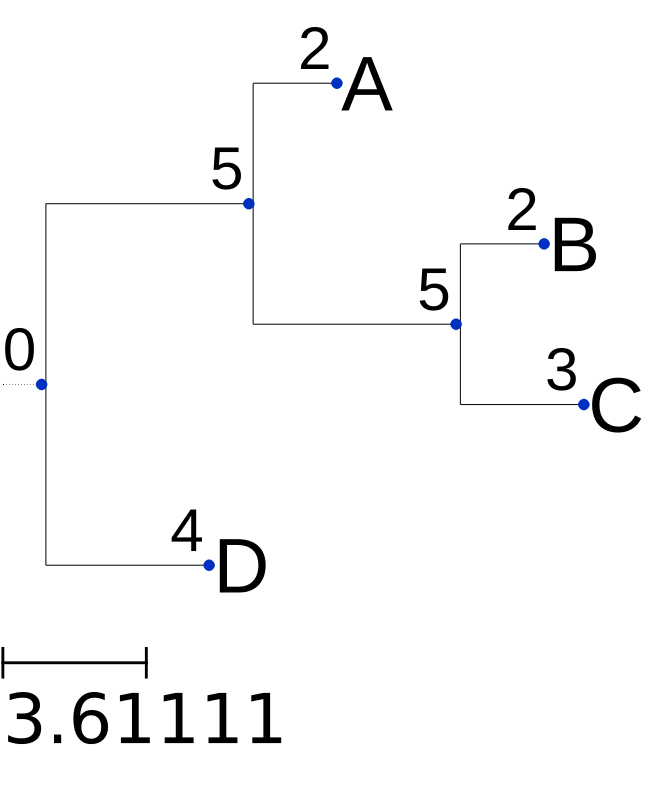

In [20]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

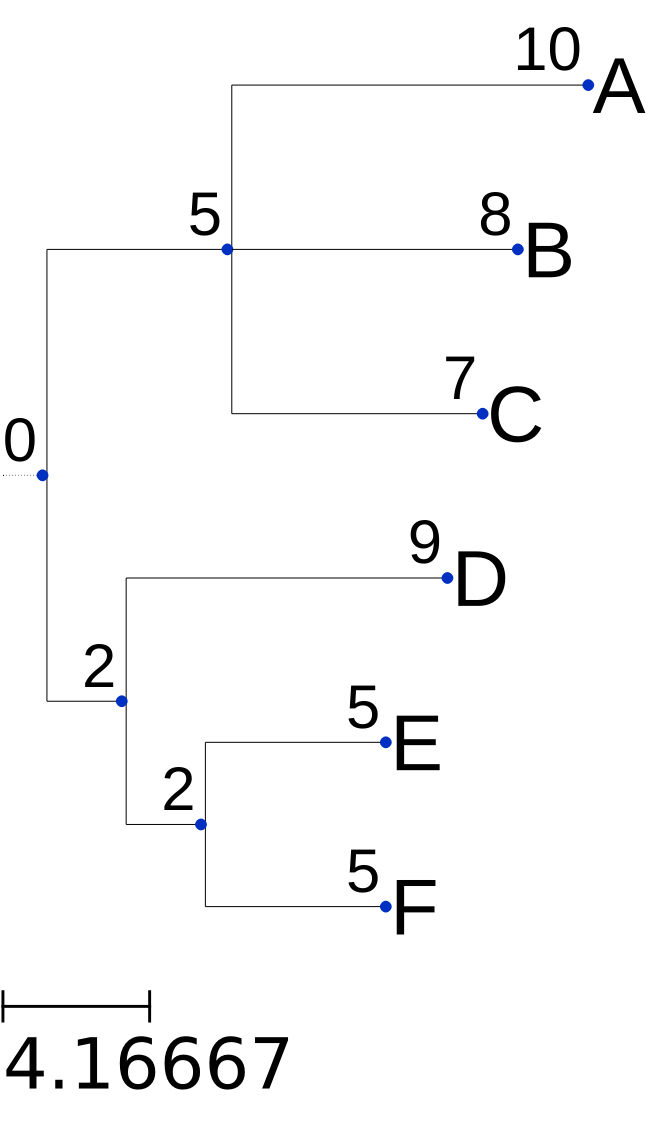

In [21]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2):0;'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'est ce qui pourrait expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse :

Il y a deux explications possibles :

- L'arbre représenté est phylogénétique. L'embranchement peut s'expliquer par deux mutations qui ont eu lieu en même temps, ce qui paraît assez peu probable. Cela veut aussi dire que A B et C ont le même parent, et qu'ils sont tous apparentés de manière égale.
- L'arbre est une instance temporaire de la construction d'un arbre à travers l'algorithme de neighbour-joining. Cette hypothèse nous a l'air plus plausible car A B C sont moins similaire entre eux que D E F. De plus, E et F sont très proche et sont regroupés ensemble. Et D est autant similaire à E et F et l'est moins avec A B C. A cet état de l'algorithme de Neighbor Joining, il reste les UT ABC à regrouper pour construire l'arbre phylogénétique.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=1$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ (distance((A,D),B) = 2) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [24]:
#function and module that are used in UPGMA

import itertools

# Given a string that represents a group of species like so : (toto,tata), it will return ['toto','tata']

debug = False

def string_key_to_list(s):
    tmp = s.replace('(', '#').replace(')', '#').replace(',', '#').split('#')
    # Remove the '' and the max temporary weight

    res = []

    for j in range(len(tmp)):
        if tmp[j] != '' and tmp[j][0] != ':':
            res.append(tmp[j])

    return res


def two_group_into_tree(t, dl, dr, dmax):
    left = replace_max(t[0], dl)
    right = replace_max(t[1], dr)
    return '(' + left + ',' + right + '):' + str(dmax)

# t[0] must be f and t[1] g


def new_node_u(t, df, dg):
    return '(' + t[0] + ':' + str(df) + ',' + t[1] + ':' + str(dg) + ')'


def replace_max(old_s, new_max):
    l = old_s.split(':')
    if len(l) <= 1:
        return old_s + ':' + str(new_max)
    else:
        l[-1] = str(new_max)
        s = ":"
        return s.join(l)


def print_dict(t):
    for key in t:
        print(key + " : " + str(t[key]))

In [25]:
# UPGMA Algorithm
# Input : seq_dict => dictionnary
#         dist_mat => string
# Output : String that represents a tree in Newick Format
def upgma(seq_dict, dist_mat):
    # Number of taxa
    n = len(seq_dict)

    # Array of taxas
    tab_specie = np.array([key for key, value in seq_dict.items()])

    # Convert the distance matrix into distance hashtbl
    dist_dict = {}
    for i in range(n):
        for j in range(i):
            dist_dict[tab_specie[i] + "#" + tab_specie[j]] = dist_mat[i][j]

    # Debug
    if debug:
        n = 6
        tab_specie = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
        dist_dict = {
            'a#b': 19,
            'a#c': 27,
            'a#d': 8,
            'a#e': 33,
            'a#f': 18,
            'a#g': 13,
            'b#c': 31,
            'b#d': 18,
            'b#e': 36,
            'b#f': 6,
            'b#g': 13,
            'c#d': 26,
            'c#e': 41,
            'c#f': 32,
            'c#g': 29,
            'd#e': 31,
            'd#f': 17,
            'd#g': 14,
            'e#f': 35,
            'e#g': 1,
            'f#g': 12
        }

    # The dict that keeps tracks of which specie is in the matrix
    specie_dict = {}
    for x in tab_specie:
        specie_dict[x] = True

    # The computed distance matrix
    current_dist_dict = dist_dict.copy()

    # Loop while there is more than two cells in the table
    while len(current_dist_dict) >= 1:
        # Rebuild the dictionnary at each iteration
        tmp = {}

        # Min couple represent the couple of group of taxa that have the smallest
        # distance
        min_couple = min(current_dist_dict, key=current_dist_dict.get)

        # Convert the key into a list of key, because min_cuouple is
        # equal to something similar to 'a#b' -> ['a','b']
        min_couple_list = min_couple.split('#')

        # Get the distance
        min_couple_value = current_dist_dict[min_couple]

        # Fetch the depth of the left and right tree from the min couple
        try:
            length_left = float(min_couple_list[0].split(':')[-1])
        except ValueError:
            length_left = 0

        try:
            length_right = float(min_couple_list[1].split(':')[-1])
        except ValueError:
            length_right = 0

        # Compute the distance of the min couple to the new root
        new_dist_left = (min_couple_value / 2) - length_left
        new_dist_right = (min_couple_value / 2) - length_right
        length_new = min_couple_value / 2

        # Create the new key that is a newick tree
        min_couple_key = two_group_into_tree(
            min_couple_list, new_dist_left, new_dist_right, length_new)

        # If we only have 2 groups, we can return
        if len(current_dist_dict) == 1:
            l = min_couple_key.split(":")
            res = ":".join(l[:-1]) + ";"
            return res

        # Remove the two from the know specie
        specie_dict.pop(min_couple_list[0])
        specie_dict.pop(min_couple_list[1])

        # How many item in the first cluster
        n1 = len(string_key_to_list(min_couple_list[0]))
        # How many item in the second cluster
        n2 = len(string_key_to_list(min_couple_list[1]))
        # Sum of the two before
        nbis = n1 + n2

        # Functios that compute the distance to the newly formed
        # tree to the rest of the taxas
        def f1(a): return (n1 * a)/(nbis)

        def f2(a): return (n2 * a)/(nbis)

        # The distance between the newly formed tree and the rest
        for specie in specie_dict:
            try:
                dik = current_dist_dict[min_couple_list[0]+"#"+specie]
            except:
                dik = current_dist_dict[specie+"#"+min_couple_list[0]]

            try:
                djk = current_dist_dict[min_couple_list[1]+"#"+specie]
            except:
                djk = current_dist_dict[specie+"#"+min_couple_list[1]]

            tmp[min_couple_key + '#' + specie] = f1(dik) + f2(djk)

        # Recreate the matrix for the rest of the taxa that wasn't changed
        for k1, k2 in itertools.combinations(specie_dict, 2):
            key = k1 + '#' + k2
            try:
                tmp[key] = current_dist_dict[key]
            except:
                tmp[key] = current_dist_dict[k2 + '#' + k1]

        # Add the newly formed tree into the dict that keeps track of whick specie is in the matrix
        specie_dict[min_couple_key] = True

        # Update the matrix/dict of distances
        current_dist_dict = tmp

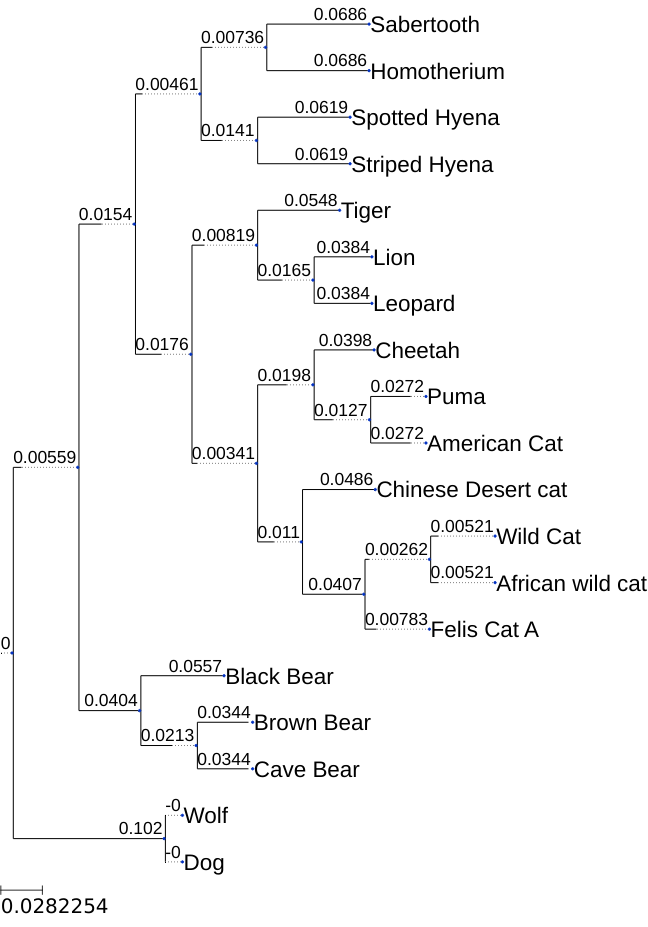

In [26]:
#compute upgma and display the result tree

upgma_tree = upgma(dict_cat_dna, dist_mat)
t = Tree(upgma_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : Les hypothéses faites par **UPGMA** sont l'horloge moléculaire, c'est-à-dire que le génome de chaque UT évolue à une vitesse constante. Si on fait l'enracinement au poids moyen, l'arbre obtenu est ultramétrique, où tous les UT se retrouvent à même distance de la racine (à quelques décimale près dans notre cas), ce qui confirme l'hypothése.

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : On peut faire l'enracinement avec groupe extérieur, mais on n'a pas fait d'analyse d'un groupe de séquence homologue à celles analysées, puisque nous avons seulement un ensemble de séquences. De plus on pourrait ne pas garder la forme ultramétrique requise pour UPGMA.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining et appliquer-le aux données.

In [31]:
# NJ Algorithm
# Input : seq_dict => dictionnary
#         dist_mat => string
# Output : String that represents a tree in Newick Format

def neighbor_joining(seq_dict, dist_mat):

    # Debug
    if debug:
        n = 6
        tab_specie = ['a', 'b', 'c', 'd', 'e']
        dist_dict = {
            "a#b": 5,
            "a#c": 9,
            "a#d": 9,
            "a#e": 8,
            "b#c": 10,
            "b#d": 10,
            "b#e": 9,
            "c#d": 8,
            "c#e": 7,
            "d#e": 3
        }
    else:
        # Number of taxa
        n = len(seq_dict)

        # Array of taxas
        tab_specie = np.array([key for key, value in seq_dict.items()])

        # Convert the distance matrix into distance hashtbl
        dist_dict = {}
        for i in range(n):
            for j in range(i):
                dist_dict[tab_specie[i] + "#" + tab_specie[j]] = dist_mat[i][j]

    # The dict that keeps tracks of which specie is in the matrix
    specie_dict = {}
    for x in tab_specie:
        specie_dict[x] = True

    # The computed distance matrix
    current_dist_dict = dist_dict.copy()

    # Loop while there is more than two cells in the table
    while len(current_dist_dict) >= 1:
        # The matrix Q
        Q = dict()

        # Rebuild the dictionnary at each iteration
        tmp = {}

        # Build the Q matrix
        specie_list = list(specie_dict.keys())
        for i in range(len(specie_list)):
            for j in range(i):
                try:
                    tmp_q = (len(specie_list) - 2) * \
                        current_dist_dict[specie_list[i]+"#"+specie_list[j]]
                except:
                    tmp_q = (len(specie_list) - 2) * \
                        current_dist_dict[specie_list[j]+"#"+specie_list[i]]
                sum1 = 0
                sum2 = 0
                for k in range(len(specie_list)):
                    if i != k:
                        try:
                            sum1 += current_dist_dict[specie_list[i] +
                                                      "#"+specie_list[k]]
                        except:
                            sum1 += current_dist_dict[specie_list[k] +
                                                      "#"+specie_list[i]]
                    if j != k:
                        try:
                            sum2 += current_dist_dict[specie_list[j] +
                                                      "#"+specie_list[k]]
                        except:
                            sum2 += current_dist_dict[specie_list[k] +
                                                      "#"+specie_list[j]]
                Q[specie_list[i]+"#"+specie_list[j]] = tmp_q - sum1 - sum2

        # Min couple represent the couple of group of taxa that have the smallest
        # distance, it's the new node u
        min_couple = min(Q, key=Q.get)

        # Convert the key into a list of key, because min_cuouple is
        # equal to something similar to 'a#b' -> ['a','b']
        min_couple_list = min_couple.split('#')

        # The other key that works
        min_couple_bis = min_couple_list[1] + '#' + min_couple_list[0]

        # Get the distance
        try:
            min_couple_value = current_dist_dict[min_couple]
        except:
            min_couple_value = current_dist_dict[min_couple_bis]

        # If we only have 2 groups, we can return
        if len(current_dist_dict) == 1:
            w = min_couple_value/2
            return '(' + min_couple_list[0] + ':' + str(w) + ',' + min_couple_list[1] + ':' + str(w) +');'

       
        # Compute the distance of the min couple to the new root
        sum_f_k = 0
        sum_g_k = 0
        f = min_couple_list[0]
        g = min_couple_list[1]
        for k in range(len(specie_list)):
            if f != specie_list[k]:
                try:
                    sum_f_k += current_dist_dict[f+"#"+specie_list[k]]
                except:
                    sum_f_k += current_dist_dict[specie_list[k]+"#"+f]
            if g != specie_list[k]:
                try:
                    sum_g_k += current_dist_dict[g+"#"+specie_list[k]]
                except:
                    sum_g_k += current_dist_dict[specie_list[k]+"#"+g]

        new_dist_f = (min_couple_value / 2) + (sum_f_k -
                                               sum_g_k) / (2 * ((len(specie_dict) - 2)))
        try:
            new_dist_g = current_dist_dict[min_couple] - new_dist_f
        except:
            new_dist_g = current_dist_dict[min_couple_bis] - new_dist_f

        # Create the new node
        min_couple_key = new_node_u(min_couple_list, new_dist_f, new_dist_g)

        # Remove the two from the known specie
        specie_dict.pop(min_couple_list[0])
        specie_dict.pop(min_couple_list[1])

        # The distance between the newly node and the rest
        for specie in specie_dict:
            try:
                dfk = current_dist_dict[min_couple_list[0]+"#"+specie]
            except:
                dfk = current_dist_dict[specie+"#"+min_couple_list[0]]
            try:
                dgk = current_dist_dict[min_couple_list[1]+"#"+specie]
            except:
                dgk = current_dist_dict[specie+"#"+min_couple_list[1]]

            tmp[min_couple_key + '#' + specie] = 1 / \
                2 * (dfk + dgk - min_couple_value)

        # Recreate the matrix for the rest of the taxa that wasn't changed
        specie_list = list(specie_dict.keys())
        for i in range(len(specie_list)):
            for j in range(i):
                key = specie_list[i] + '#' + specie_list[j]
                try:
                    tmp[key] = current_dist_dict[key]
                except:
                    key_bis = specie_list[j] + '#' + specie_list[i]
                    tmp[key] = current_dist_dict[key_bis]

        # Add the newly formed tree into the dict that keeps track of whick specie is in the matrix
        specie_dict[min_couple_key] = True

        # Update the matrix/dict of distances
        current_dist_dict = tmp

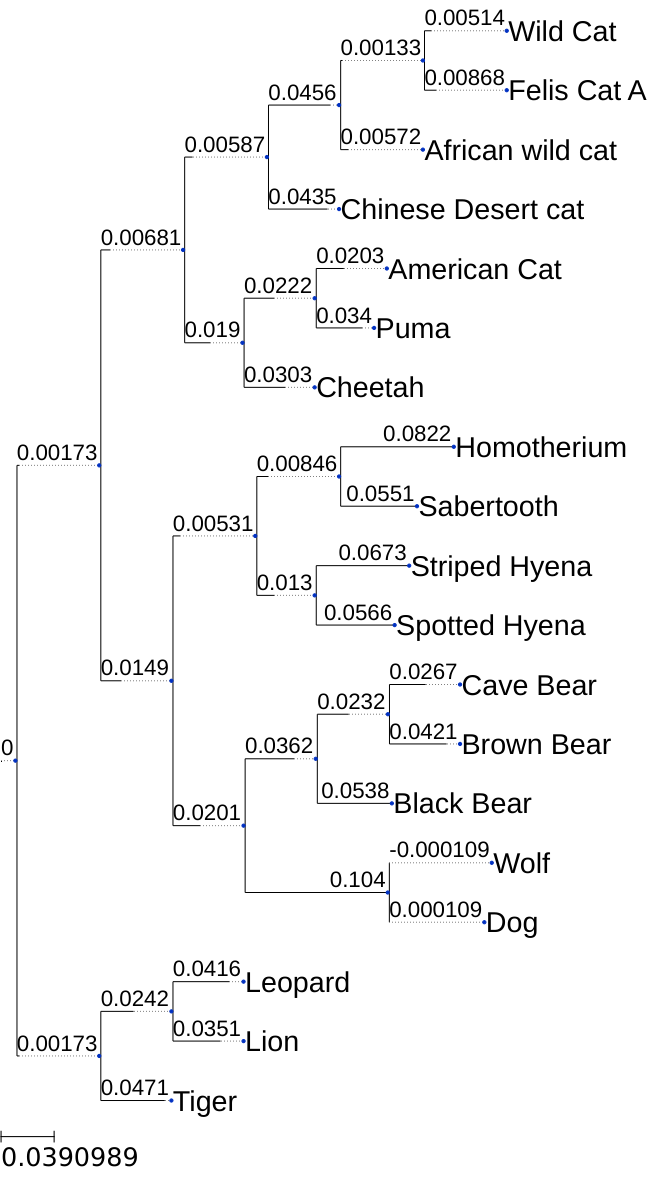

In [33]:
#compute neighbor_joining and display the result tree

neighbor_joining_tree = neighbor_joining(dict_cat_dna, dist_mat)
t = Tree(neighbor_joining_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

----
## Conclusion

**Exercice 11 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse : Nous allons partir de la supposition que American Cat est le M.Trumani/American Cheetah. En partant du principe que les algorithmes sont correctes, le American Cat est plus proche du puma que du Felis Cat (le chat domestique). De plus quand on compare l'American Cheetah et le puma, ils se ressemblent plus l'un avec l'autre que l'American Cheetah avec le Cheetah (on assume qu'il s'agit du guépard qu'on retrouve en Afrique). Par exemple, ils n'ont pas la même "corpulence": le guépard africain a l'air un peu plus fin. Le puma et le american cat ont le meme pelage et pas de motifs sur leur corps, contrairement au guépard africain qui en a. Ces différences morphologiques peuvent s'expliquer par le fait qu'une population d'un ancêtre commun aux 3 OTUs se soient divisé, l'un allant dans le continent américain, l'autre dans le continent africain.

Le smilodon et homotherium se ressemblent morphologiquement. Deux longues dents de la rangée haute des dents se retrouvent en dehors de la machoire même lorsqu'ils ferment la machoire. Comparé aux autres felins comme le tigre ou le lion, leur queue est plus courte. On voit qu'ils sont plus apparentés aux hyénes que les autres OTUs. Quelques théories (https://en.wikipedia.org/wiki/Smilodon#Predatory_behavior) suggére que les Smilodons utilisaient leur dents pour effrayer les autres animaux pour s'approprier un cadavre (comportement de charognards similaire aux hyénes) ou préférait utiliser leur dents pour délivrer un coup fatal, contrairement aux autres félins qui utilisent leur membres pour immobiliser leur victime. Les observations morphologiques se confirment lorsqu'on étudie l'arbre phylogénique de ses espèces: ils ne sont pas très proches des félins actuels.

Si les 3 OTUs se ressemblent, c'est parce que ils ont évolués dans le même environment et grâce à la selection naturelle, les caractéristiques qui leur permettent de survivre ont été retenus au cours des générations.

Les deux arbres donnent à peu près les memes relations de parentés. La différence est dans quel ordre apparaissent les taxons et la distance par rapport aux parents. On voit que l'arbre de NJ est sensé être plus précis mais ne fait pas l'enracinement, c'est pour cela que le groupe des tigres/lions/léopard se retrouvent en dehors du groupe de taxon des félins. Nous avons juste enraciné en rejoignant les deux derniers groupes de taxon.

Source : 
- https://www.researchgate.net/profile/Ross_Barnett/publication/7675631_Evolution_of_the_extinct_Sabretooths_and_the_American_cheetah-like_cat_2/links/5bc87dd0458515f7d9c54581/Evolution-of-the-extinct-Sabretooths-and-the-American-cheetah-like-cat-2.pdf
- https://computationalgenomics.blogs.bristol.ac.uk/case_studies/sabertooth_demo